Reference- "Input Pipeline for Images using Keras and TensorFlow - Guide to creating an input pipeline for custom image dataset for deep learning models using Keras and TensorFlow" by Renu Khandelwal (Aug 21)
https://towardsdatascience.com/input-pipeline-for-images-using-keras-and-tensorflow-c5e107b6d7b9

### Import modules

In [1]:
#%matplotlib inline

import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from PIL import Image
import cv2

### Setup the GPU memory growth

In [2]:
### Taken from- https://github.com/tensorflow/tensorflow/issues/34695
### This was done to resolve the error: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


### Set parameters

In [4]:
# Full dataset
train_data_dir=r'data_mip3_aug/train'
test_data_dir=r'data_mip3_aug/test'

# Calculation of max batch size-
# Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
# size of tensors = batch_size*100*100 *4 if using 64 bit integers

batch_size = 256
test_batch_size = 256
img_height = 100
img_width = 100
mean = 157.1
std = 64.6
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Create filelist datasets
### tf.data.Dataset.list_files() creates a dataset from a directory list of files using a matching pattern.

In [5]:
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir + '/*/*'), shuffle=False)
# get the count of image files in the train directory
train_image_count=0
for dir1 in os.listdir(train_data_dir):
    for files in os.listdir(os.path.join(train_data_dir, dir1)):
        train_image_count+=1
train_list_ds = train_list_ds.shuffle(train_image_count, reshuffle_each_iteration=False)
print(train_image_count)

1345680


In [6]:
# Print some filenames
for x in train_list_ds.take(5):
    print(x.numpy().decode('utf-8'))

data_mip3_aug/train/connection/C9_(32725,15713,94)_rot50_17.png
data_mip3_aug/train/no_connection/R52_(26592,20616,857)_6.png
data_mip3_aug/train/no_connection/R109_(20032,17152,231)_18.png
data_mip3_aug/train/connection/C15_(30940,7320,1907)_rot20_11.png
data_mip3_aug/train/connection/C4_(26552,14826,1469)_rot90_16.png


In [7]:
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir + '/*/*'), shuffle=False)
# get the count of image files in the train directory
test_image_count=0
for dir1 in os.listdir(test_data_dir):
    for files in os.listdir(os.path.join(test_data_dir, dir1)):
        test_image_count+=1
test_list_ds = test_list_ds.shuffle(test_image_count, reshuffle_each_iteration=False)
print(test_image_count)

347760


In [8]:
# Use this function to list files from a filelist dataset, such as test_list_ds.
# This may be useful later
list_files_from_tfdataset = lambda tfd: [f.numpy().decode('utf-8') for f in tfd]

In [9]:
#l = list_files_from_tfdataset(test_list_ds)
#print(len(l))
#del(l)

In [10]:
#test_ds_filepaths = test_list_ds.take(test_image_count)

### Creating class labels from the directory name

In [11]:
class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_data_dir)]))
class_names

array(['connection', 'no_connection'], dtype='<U13')

### Splitting the dataset into train, and Val.
The validation dataset is 30% of the total dataset, and train dataset is 70% of the entire dataset.

In [12]:
# Create training and validation datasets
val_size = int(train_image_count * 0.3)
train_ds = train_list_ds.skip(val_size)
val_ds = train_list_ds.take(val_size)
print(train_image_count-val_size, val_size)

941976 403704


In [13]:
# Different way of creatint training and validation datasets
# This is useful to select only small subset of the full data
#val_size = int(train_image_count * 0.01)
#train_size = int(train_image_count * 0.03)
#train_ds = train_list_ds.take(train_size)
#remaining_list_ds = train_list_ds.skip(train_size)
#val_ds = remaining_list_ds.take(val_size)
#print(train_size, val_size)

In [14]:
# Print some filenames
for x in train_ds.take(5):
    print(x.numpy().decode('utf-8'))

data_mip3_aug/train/no_connection/R61_(28544,12600,1091)_rot20_35.png
data_mip3_aug/train/connection/C11_(18088,13158,1204)_rot90_28.png
data_mip3_aug/train/connection/C12_(15688,10491,1013)_rot10_26.png
data_mip3_aug/train/no_connection/R131_(32716,12560,1952)_rot50_21.png
data_mip3_aug/train/no_connection/R7_(19912,14200,2)_rot20_28.png


In [15]:
# Create test dataset
test_ds = test_list_ds.take(test_image_count)

### Creating input pipeline components for a single training/validation example representing a pair of tensors to represent the image and its corresponding label.

In [16]:
#To process the label
def get_label(filepath):
    # convert the path to a list of path components separated by sep
    parts = tf.strings.split(filepath, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(tf.cast(one_hot, tf.int32))
    
    #label = tf.strings.split(filepath, sep='/')
    #label = tf.strings.split(label[-1], sep='.')

# To process the image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    #img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.decode_png(img, channels=1)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

# To create the single training of validation example with image and its corresponding label
def process_path(filepath):
    label = get_label(filepath)
    # load the raw data from the file as a string
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label

### Set the AUTOTUNE; this will help to delegate the decision on the level of parallelism to use to the tf.data at runtime to optimize the CPU/GPU utilization.

In [17]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [18]:
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
# Test if the datasets are prepared correctly
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype, labels.numpy())
    img = (img-5)/2 # Testing mathematical operations on tensor
    print(img.min(), img.max(), img.dtype, labels.numpy())

(100, 100, 1) ()
200.0 255.0 float32 1
97.5 125.0 float32 1


### Set augmentation and normalization functions

In [20]:
def augment(image, label):
    img = tf.image.rot90(image)
    img = tf.image.flip_left_right(img)
    #img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

def standardize_per_image(image, label):
    img = tf.image.per_image_standardization(image)
    return img, label

def standardize_dataset(image, label):
    # NOTE: mean and std have to be defined globally
    # Not checking that mean and std are > 0 to avoid time lag. So be careful with the values of mean and std.
    img = (image - mean)/std
    return img, label

### Configure data source for Performance
To configure the data source for performance, use prefetching.
Prefetching in tf.data allows the preprocessing of the data and model execution of a training step to overlap.
While the model is executing a training step 100, the input pipeline is reading the data for step 101.

In [21]:
def configure_for_performance(ds, cache_filename):
    #ds = ds.cache()
    ds = ds.cache(cache_filename)
    ds = ds.shuffle(buffer_size=1000)
    #ds = ds.map(augment, num_parallel_calls=AUTOTUNE) # No need if pre-augmented images.
    #ds = ds.map(standardize_per_image, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    ds = ds.map(standardize_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds, '/home/harsh/tensorflow_cache/train_v5.train_ds')
val_ds = configure_for_performance(val_ds, '/home/harsh/tensorflow_cache/train_v5.val_ds')

In [22]:
def configure_for_performance_forTestDataset(ds, cache_filename):
    #ds = ds.cache()
    ds = ds.cache(cache_filename)
    #ds = ds.shuffle(buffer_size=1000)
    #ds = ds.map(standardize_per_image, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    ds = ds.map(standardize_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(test_batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

test_ds = configure_for_performance_forTestDataset(test_ds, '/home/harsh/tensorflow_cache/train_v5.test_ds')

(256, 100, 100, 1) (256,)
-2.4318886 1.5154798 float32 0


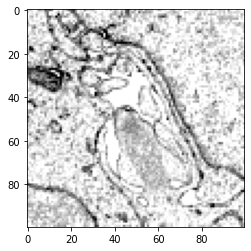

In [23]:
# Test that the pixels values are actually standardized and the images are properly stored.
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype, labels[0].numpy())
    plt.imshow(img, cmap=plt.get_cmap("gray"))

In [24]:
# Check the test dataset. This dataset is not shuffled.
# So you should see same values printed if you run it again.
for images, labels in test_ds.take(1):
    print(images.shape, labels.shape)
    #img = images[0].numpy()
    print(images[0].numpy().min(), images[0].numpy().max())
    print(images[1].numpy().min(), images[1].numpy().max())
    

(256, 100, 100, 1) (256,)
-2.2770898 1.5154798
-2.4318886 1.5154798


In [27]:
# Check if the file names can be matched with output of the test dataset
test_ds_filelist = list_files_from_tfdataset(test_list_ds) # Create test dataset file list.

(256, 100, 100, 1) (256,)
(100, 100, 1) ()
0


NameError: name 'test_ds_filelist' is not defined

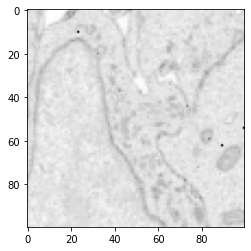

In [25]:
for images, labels in test_ds.take(1):
    print(images.shape, labels.shape)
    plt.imshow(images[2].numpy()[:,:], cmap=plt.get_cmap("gray"))
    print(images[2].numpy().shape, labels[2].numpy().shape)
    print(labels[2].numpy())
    print(test_ds_filelist[2])

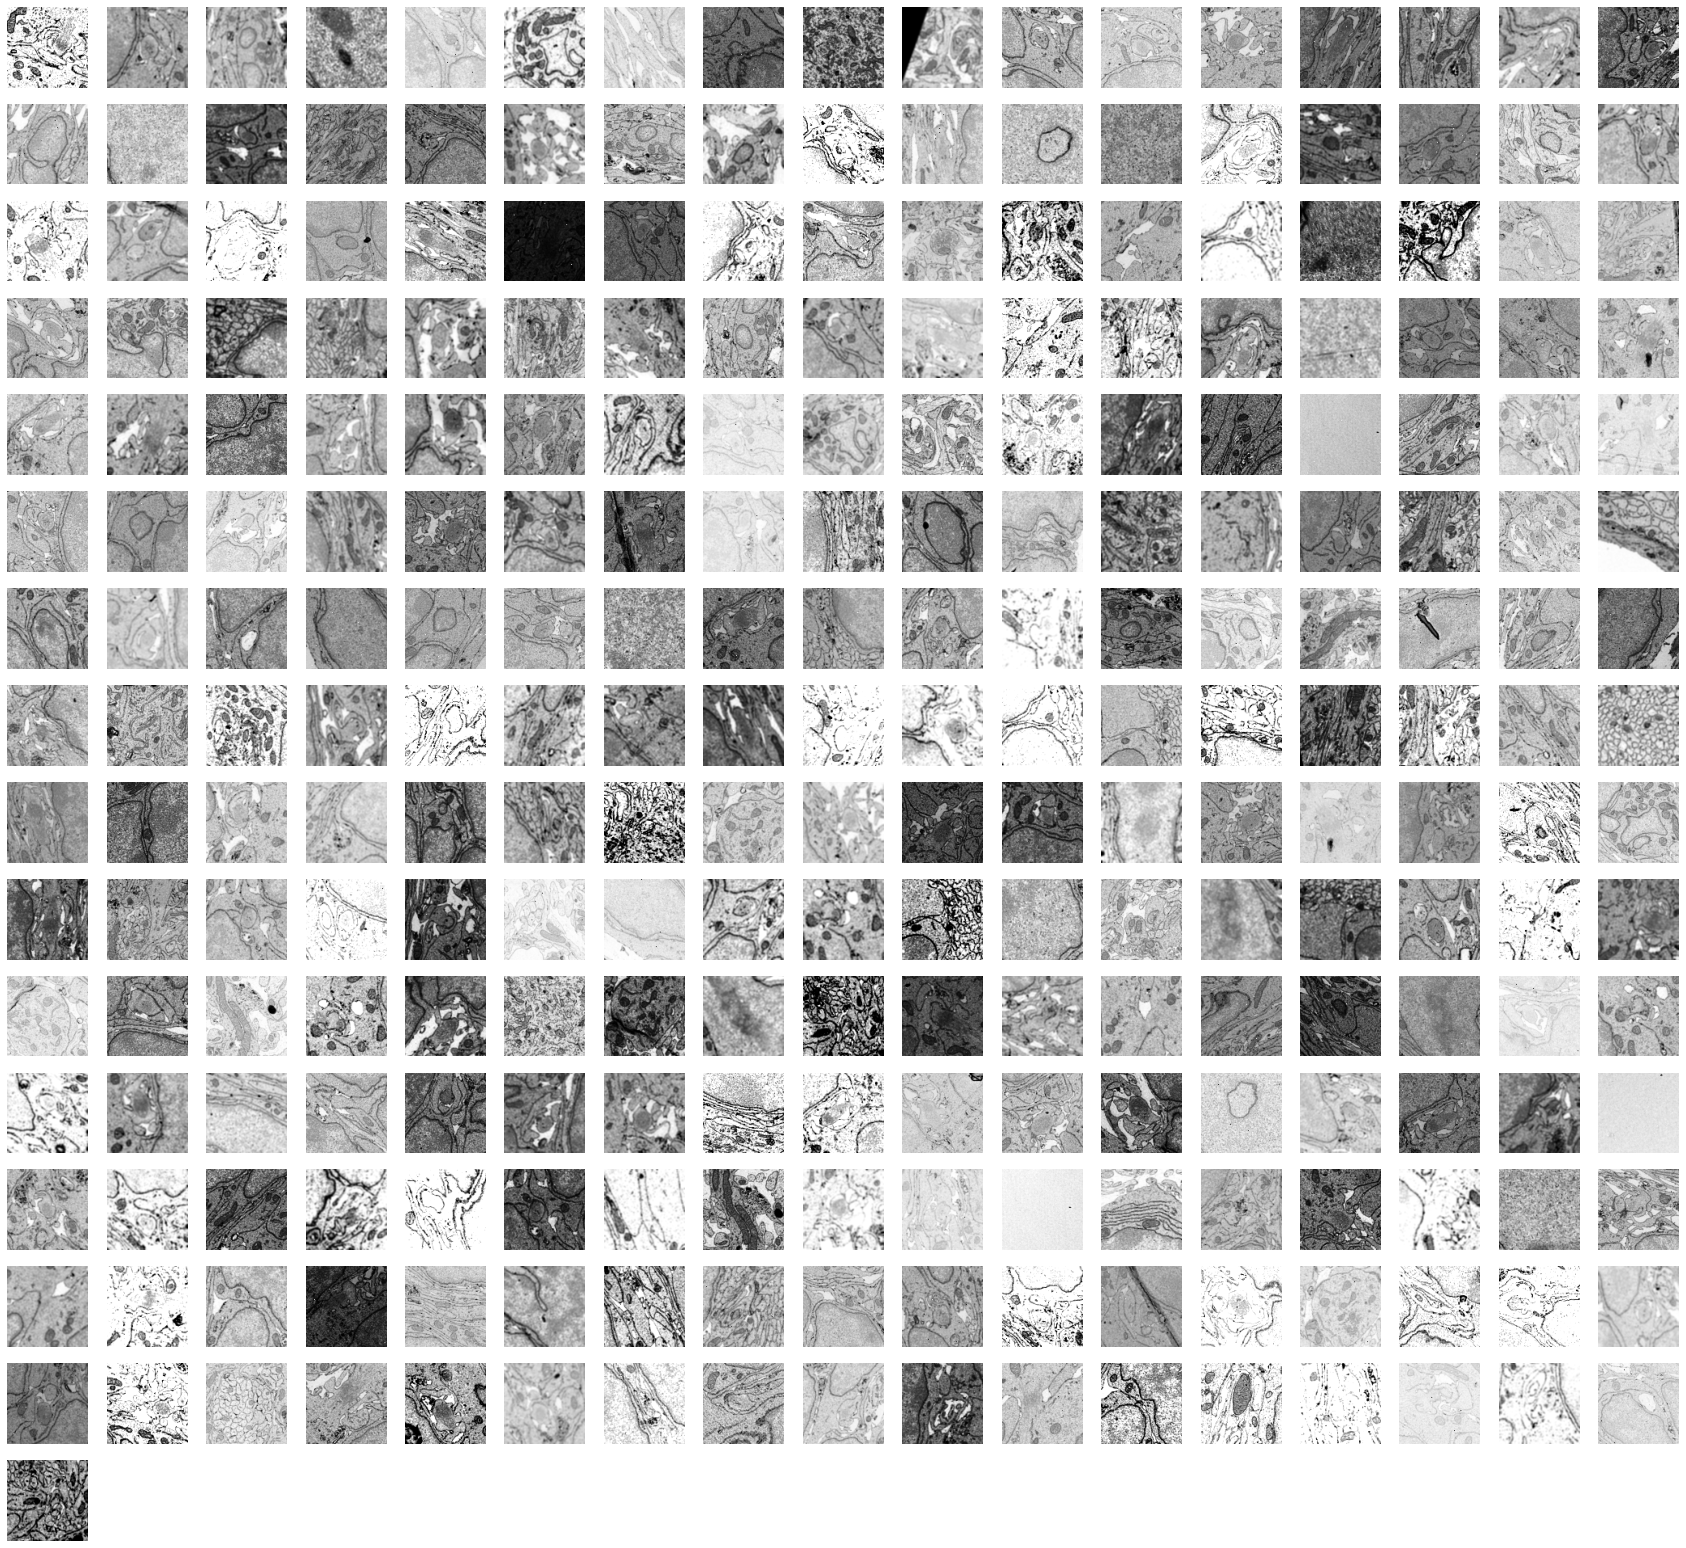

In [26]:
# Check if a batch of images from test dataset can be printed along with classnames and filenames
plt.figure(figsize=(30, 30))
cnt = 0
for images, labels in train_ds.take(1):
    #print(images.shape)
    for i in range(batch_size):
        ax = plt.subplot(int(np.sqrt(batch_size))+1, int(np.sqrt(batch_size))+1, i + 1)
        #ax = plt.subplot(12, 12, i + 1)
        #print(images[i].shape)
        plt.imshow(images[i].numpy(), cmap=plt.get_cmap("gray"))
        #plt.title(class_names[labels[i]]+"\n"+test_ds_filelist[i+cnt*batch_size].split("/")[-1].replace(".png",""))
        plt.axis("off")
    cnt += 1

### Create keras model
The input to the model is tf.data.Dataset

In [26]:
# Confirm current working directory
os.getcwd()

'/media/harsh/harsh_4tb/Segmentations/P7/connectionPrediction_CNN1'

In [ ]:
# Create callbacks
# This part is not complete.
#checkpoint_path = ""
#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

In [27]:
s="""
model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1)
         ])
"""

### TO DO:
### Try the following two alternatives
The original paper that introduced the method suggests adding batch normalization before the activation function of the previous layer, for example:

model = Sequential
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
...
model = Sequential
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))


Some reported experiments suggest better performance when adding the batch normalization layer after the activation function of the previous layer; for example:

model = Sequential
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
...
model = Sequential
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())


If time and resources permit, it may be worth testing both approaches on your model and use the approach that results in the best performance.

In [27]:
#Define model
model=tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
        ###keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(1024, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#Compile the model
model.compile(
              optimizer=opt, 
              #optimizer='adam', 
              loss='binary_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['acc']
              #metrics=['accuracy', 'f1score', 'precision', 'recall']
             )

#Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

In [25]:
#Visualize model graphically
#tf.keras.utils.plot_model(model)

### Fit model to data

In [168]:
# Scratch
#epochs = 10000
#steps_per_epoch = 1
#num_batches = steps_per_epoch * epochs
#print("Available images",image_count-val_size)
#print("Number of images required", num_batches * batch_size)
#(image_count-val_size)/68

In [29]:
#Fitting the model
history = model.fit(train_ds,
                    #steps_per_epoch=100,#(image_count-val_size) // batch_size,
                    epochs=100,
                    #validation_steps=100,#val_size // batch_size,
                    validation_data=val_ds,
                    verbose=1
                   )

Epoch 1/100
3680/3680 [==============================] - 225s 61ms/step - loss: 0.0110 - acc: 0.9961 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/100
3680/3680 [==============================] - 228s 62ms/step - loss: 0.0073 - acc: 0.9975 - val_loss: 0.0021 - val_acc: 0.9995
Epoch 3/100
3680/3680 [==============================] - 224s 61ms/step - loss: 0.0055 - acc: 0.9981 - val_loss: 9.2837e-04 - val_acc: 0.9998
Epoch 4/100
3680/3680 [==============================] - 224s 61ms/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.0051 - val_acc: 0.9984
Epoch 5/100
3680/3680 [==============================] - 224s 61ms/step - loss: 0.0035 - acc: 0.9988 - val_loss: 5.9541e-04 - val_acc: 0.9998
Epoch 6/100
3680/3680 [==============================] - 224s 61ms/step - loss: 0.0029 - acc: 0.9990 - val_loss: 1.9906e-04 - val_acc: 1.0000
Epoch 7/100
3680/3680 [==============================] - 224s 61ms/step - loss: 0.0025 - acc: 0.9991 - val_loss: 3.0207e-04 - val_acc: 0.9999
Epoch 8/10

### Save model to file

In [30]:
#model_filename = "models/model.10dec2020.data_mip3_aug.per_image_dataset"
model_filename = "models/model4.data_mip3_aug.std_dataset"
model.save(model_filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/model4.data_mip3_aug.std_dataset/assets


In [41]:
# TO DO: Save checkpoints and write to restart from latest checkpoint
# Refer- https://www.tensorflow.org/tutorials/keras/save_and_load

### Access model performance

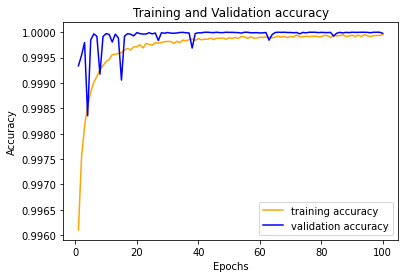

In [31]:
num_epochs = 100
acc_train = history.history['acc'][:num_epochs]
acc_val = history.history['val_acc'][:num_epochs]
epochs = range(1,num_epochs+1)
plt.plot(epochs,acc_train, 'orange', label='training accuracy')
plt.plot(epochs, acc_val, 'b', label= 'validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

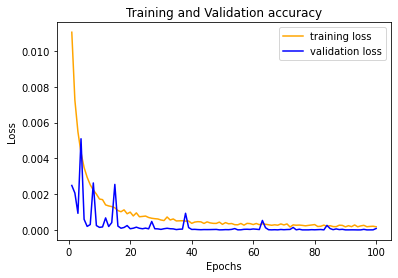

In [32]:
num_epochs = 100
loss_train = history.history['loss'][:num_epochs]
loss_val = history.history['val_loss'][:num_epochs]
epochs = range(1,num_epochs+1)
plt.plot(epochs,loss_train, 'orange', label='training loss')
plt.plot(epochs, loss_val, 'b', label= 'validation loss')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot images with true and predicted class labels

In [50]:
# Scratch
#a = val_ds.list_files("*.png")
#len(list(val_ds.list_files("*")))
#dataset_length = [i for i,_ in enumerate(val_ds)][-1] + 1
#dataset_length*batch_size
for images, labels in test_ds.take(1):
    print(images.shape, labels[0].numpy())


(128, 100, 100, 1) 1


In [34]:
def classification_report(true_labels, pred_labels):
    print("---Classification report---\n")
    confusion_matrix = metrics.confusion_matrix(true_labels, pred_labels)
    print("\t\t\tClassified as")
    print("\t\t"+"\t".join(class_names)+"\tsum")
    for i in range(0,len(class_names)):
        print(class_names[i]+"\t"+
              "\t\t".join([str(x) for x in confusion_matrix[i]])+
              "\t\t"+str(np.sum(confusion_matrix[i])))
    print("==========================================================\n")
    print("F1 scores:",metrics.f1_score(true_labels, pred_labels, average=None))
    print("==========================================================\n")
    print("metrics.classification_report:\n",metrics.classification_report(true_labels, pred_labels))

In [35]:
def get_true_pred_labels(model, dataset, num_batches):
    pred_1_to_10 = []
    pred_labels = []
    true_labels = []
    cnt = 0
    for images, labels in dataset.take(num_batches):
        #3print(images.shape, labels.shape)
        pred = model.predict(images)
        pred_temp = (pred*10).astype(int)
        #pred_temp = pred_temp.astype(int)
        #print(pred.shape, pred[:5].astype(int))
        #print(pred.shape)
        for i in range(0,pred.shape[0]):
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[int(pred[i][0]>0.5)]
            true_labels.append(true_label)
            pred_labels.append(pred_label)
            ##if true_label ==  'connection' and pred_label == 'no_connection':
                # ???Save image- Saving image is still under review
                #print(images[i].shape)
                #print(type(image), image.shape, image.min(), image.max())
                #img = Image.fromarray(np.array(255*image)).convert("L")#"RGB")#(images[i].numpy())#.astype('uint8'))
                #img.save("data_mip3/test_connection_as_noconnection/image_"+str(cnt)+".png")
                ##image = images[i].numpy()
                ##image = np.squeeze(image)
                ##image = images[5].astype('uint8')
                ##Image.fromarray(images[6].astype('uint8')).save("image_6.png")

            pred_1_to_10.append(pred_temp[i])
            cnt += 1
    pred_1_to_10 = np.array(pred_1_to_10)
    plt.hist(pred_1_to_10, bins=10) # This is to see histogram of predictions
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    print(true_labels.shape, pred_labels.shape)
    print("Unique counts in true_labels:", np.unique(true_labels, return_counts=True))
    print("Unique counts in pred_labels:", np.unique(pred_labels, return_counts=True))
    print()
    return(true_labels, pred_labels)

(25600,) (25600,)
Unique counts in true_labels: (array(['connection', 'no_connection'], dtype='<U13'), array([11915, 13685]))
Unique counts in pred_labels: (array(['connection', 'no_connection'], dtype='<U13'), array([12379, 13221]))

---Classification report---

			Classified as
		connection	no_connection	sum
connection	11244		671		11915
no_connection	1135		12550		13685

F1 scores: [0.92566066 0.93287743]

metrics.classification_report:
                precision    recall  f1-score   support

   connection       0.91      0.94      0.93     11915
no_connection       0.95      0.92      0.93     13685

     accuracy                           0.93     25600
    macro avg       0.93      0.93      0.93     25600
 weighted avg       0.93      0.93      0.93     25600



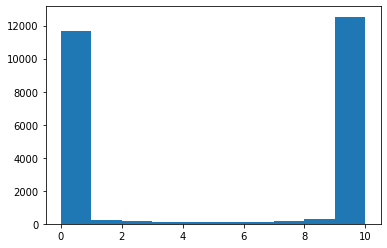

In [52]:
# Classification report for test dataset
true_labels, pred_labels = get_true_pred_labels(model, test_ds, 200)
classification_report(true_labels, pred_labels)

In [38]:
# Classification report for training dataset
#true_labels, pred_labels = get_true_pred_labels(model, train_ds, 100)
#classification_report(true_labels, pred_labels)

(12800,) (12800,)
Unique counts in true_labels: (array(['connection', 'no_connection'], dtype='<U13'), array([6955, 5845]))
Unique counts in pred_labels: (array(['connection', 'no_connection'], dtype='<U13'), array([6958, 5842]))

---Classification report---

			Classified as
		connection	no_connection	sum
connection	6954		1		6955
no_connection	4		5841		5845

F1 scores: [0.99964062 0.99957217]

metrics.classification_report:
                precision    recall  f1-score   support

   connection       1.00      1.00      1.00      6955
no_connection       1.00      1.00      1.00      5845

     accuracy                           1.00     12800
    macro avg       1.00      1.00      1.00     12800
 weighted avg       1.00      1.00      1.00     12800



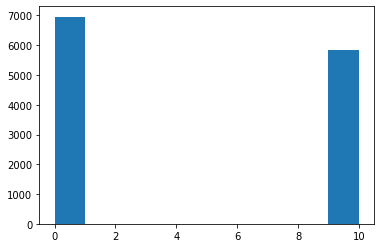

In [39]:
# Classification report for validation dataset
#true_labels, pred_labels = get_true_pred_labels(model, val_ds, 100)
#classification_report(true_labels, pred_labels)

In [87]:
# Scratch
#for images, labels in train_ds.take(1):
#    print(images[0].shape)
#    predicted = model.predict(np.array([images[0]]))

# Get list of files in the test dataset
test_ds_filelist = list_files_from_tfdataset(test_list_ds)

##plt.figure(figsize=(15, 18))
cnt = 0
for images, labels in test_ds.take(2):
    #print(images.shape)
    for i in range(batch_size):
        #print(images[i].shape)
        pred = model.predict(np.array([images[i]]))
        pred_class = class_names[int(pred[0][0]>0.5)]
        true_class = class_names[labels[i]]
        print(test_ds_filelist[i+cnt*batch_size], true_class, pred_class)
        #if pred_class == true_class:
        ##ax = plt.subplot(int(np.sqrt(batch_size)), int(np.sqrt(batch_size)), i + 1)
        ##plt.imshow(images[i].numpy(), cmap=plt.get_cmap("gray"))
        ##plt.title(true_class+"\n"+pred_class)
        ##plt.axis("off")
        #print("found")
    cnt += 1

data_mip3/test/connection/C22_Carolina_(13588,11256,1182).png connection connection
data_mip3/test/no_connection/R129_(30224,10912,1952).png no_connection no_connection
data_mip3/test/no_connection/R141_(36680,46140,2159).png no_connection no_connection
data_mip3/test/no_connection/R114_(27832,9388,128).png no_connection no_connection
data_mip3/test/connection/C22_Carolina_(13583,11166,1186).png connection connection
data_mip3/test/no_connection/R94_(34596,20772,22).png no_connection no_connection
data_mip3/test/no_connection/R116_(22508,19648,1002).png no_connection no_connection
data_mip3/test/connection/C22_Carolina_(13604,11126,1170).png connection no_connection
data_mip3/test/no_connection/R94_(34596,20672,23).png no_connection no_connection
data_mip3/test/no_connection/R117_(24228,20824,1000).png no_connection no_connection
data_mip3/test/no_connection/R69_(23964,10756,1309).png no_connection no_connection
data_mip3/test/no_connection/R21_(30194,24254,304).png no_connection no_co

data_mip3/test/connection/C1_(23926,15373,2273).png connection connection
data_mip3/test/no_connection/R72_(21496,10524,1598).png no_connection no_connection
data_mip3/test/connection/C17_(15714,8122,1379).png connection connection
data_mip3/test/no_connection/R114_(27732,9288,132).png no_connection no_connection
data_mip3/test/connection/C22_Carolina_(13596,11341,1176).png connection connection
data_mip3/test/no_connection/R143_(23732,21248,2043).png no_connection no_connection
data_mip3/test/no_connection/R115_(26468,12224,390).png no_connection no_connection
data_mip3/test/no_connection/R147_(27152,13896,2308).png no_connection no_connection
data_mip3/test/no_connection/R129_(30324,11012,1951).png no_connection no_connection
data_mip3/test/connection/C22_Carolina_(13671,11288,1195).png connection connection
data_mip3/test/no_connection/R144_(31868,17728,2214).png no_connection connection
data_mip3/test/no_connection/R72_(21396,10624,1597).png no_connection no_connection
data_mip3/te

### Predict on the full EM volume

In [16]:
# Functions to prepare data for prediction

#def process_array(array):
#    # load the raw data from the file as a string
#    #img = tf.io.read_file(filepath)
#    img = decode_img(array)
#    return img

def standardize_per_image_forUnknownData(image):
    img = tf.image.per_image_standardization(image)
    return img

def standardize_dataset_forUnknownData(image):
    # NOTE: mean and std have to be defined globally
    # Not checking that mean and std are > 0 to avoid time lag. So be careful with the values of mean and std.
    img = (image - mean)/std
    return img

def configure_for_performance_forUnknownData(ds):
    ds = ds.cache()
    #ds = ds.shuffle(buffer_size=1000)
    #ds = ds.map(standardize_per_image_forUnknownData, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    ds = ds.map(standardize_dataset_forUnknownData, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(test_batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [17]:
# Load model from saved model (optional)
model1 = tf.keras.models.load_model('models/model1.data_mip3_aug.std_dataset')

In [26]:
# Read images exported for the full EM volume

full_em_data_dir = "../P7_em_export_mip3"

full_em_filenames = sorted(os.listdir(full_em_data_dir))
num_slices = len(full_em_filenames)
print("Total number of slices:", num_slices)
step_w = int(img_width/2)
step_h = int(img_height/2)
co = [] # Coordinates
s = 0 # Slice number
for filename in full_em_filenames:
    #print(filename)
    image = cv2.imread(full_em_data_dir+"/"+filename, cv2.IMREAD_GRAYSCALE)
    h, w = image.shape
    #print(w, h)
    #print(len(list(range(0, h-img_height, step_h))))
    #print(len(list(range(0, w-img_width, step_w))))
    tiles_top_left = []
    tiles_center = []
    tiles = []
    for i in range(0, h-img_height, step_h):
        for j in range(0, w-img_width, step_w):
            tiles_top_left.append((i,j))
            tiles_center.append((i+int(img_height/2), j+int(img_width/2)))
            tiles.append(np.expand_dims(image[i:i+img_height,j:j+img_width].astype('float32'), axis=2))
    
    #print(tiles[0].shape)
    # Store tiles of this slice as tensorflow dataset
    images_ds = tf.data.Dataset.from_tensor_slices(np.array(tiles))
    images_ds = configure_for_performance_forUnknownData(images_ds)

    """
    # Check if images_ds is correctly prepared
    arr = []
    flag = 0
    nonzerocnt = 0
    for img in images_ds.take(10):
        #print(img.shape)
        for i in range(img.shape[0]):
            if np.sum(img[i].numpy()) > 0:
                #print(np.sum(img[i].numpy()))
                arr.append(img[i].numpy()[:,:])
                nonzerocnt += 1
                #flag = 1
                #break
        #if flag:
        #    break
    print(nonzerocnt)
    #print(img[0].numpy()[:,:].sum())
    plt.imshow(arr[0], cmap=plt.get_cmap("gray"))
    #print(img[34].numpy())
    break
    """
    
    #images = images.map(process_array, num_parallel_calls=AUTOTUNE)
    #print(tiles_top_left[10000])
    #print(8*tiles_top_left[10000][0], 8*tiles_top_left[10000][1])
    #print(tiles_center[10000])
    #print(8*tiles_center[10000][0], 8*tiles_center[10000][1])
    #plt.imshow(tiles[10000], cmap=plt.get_cmap("gray"))
    
    # Predict
    pred = model1.predict(images_ds)
    pred_class = class_names[int(pred[0][0]>0.5)]
    #true_class = class_names[labels[i]]
    #print(test_ds_filelist[i+cnt*batch_size], true_class, pred_class)
    #pred = pred.squeeze()
    #print(len(tiles), pred.shape, pred_class)
    
    # Get coordinates for tiles with pred value <= 0.5
    regions = [] #???Check if regions list is needed
    for n in range(0,pred.shape[0]):
        if pred[n][0] <= 0.5: # Predicted value close to zero is for the connection class
            regions.append(n)
            co.append(list(tiles_top_left[n])+[s]) # co is used to store the top left coordinates of chosen tiles.
    #print(len(regions), regions[1], len(co), co[:5])
    #plt.imshow(tiles[regions[10]])
    # Write images at same resolution with different gray scales for identified blocks
    
    s += 1
    #break

# Convert co to numpy array
co = np.array(co)
print("Used slices:", s)
print("Image size was:", h, w)

Total number of slices: 2514
Used slices: 2513
Image size was: 8750 7500


In [55]:
# Check the obtained coordinates
print("Shape of co:", co.shape)
print("Example coordinate in co:", co[0])
print("Example coordinate in co:", co[1744427])

Shape of co: (1744428, 3)
Example coordinate in co: [ 650 3600    0]
Example coordinate in co: [6300 5500 2513]


In [57]:
# Rolling cube (or box) approach
boxh = 300 # box height
boxw = 300 # box width
boxd = 30  # box depth

# box stores the coordinates in terms of box index space (Not in terms of the pixel/voxel space)
box = np.zeros((h//boxh+1,w//boxw+1,num_slices//boxd+1))
print("box shape:", box.shape)
print("Total number of boxes:", box.shape[0]*box.shape[1]*box.shape[2])
print("Number of tiles in one box =", int(boxh/img_height * boxw/img_width * boxd))
print("Box sum (before filling):", box.sum())

for i in range(0,co.shape[0]):
    x = co[i][0]//boxh
    y = co[i][1]//boxw
    z = co[i][2]//boxd
    box[x,y,z] += 1

print("Box sum (after filling):", box.sum())
print("Box shape:", box.shape)

box shape: (30, 26, 84)
Total number of boxes: 65520
Number of tiles in one box = 270
Box sum (before filling): 0.0
Box sum (after filling): 1744428.0
Box shape: (30, 26, 84)


In [84]:
# In this block, decide how many cubes are to be saved as hotspots in the segmented images.
# The number of cubes obtained is the number of segments that will be created in the segmented images.

# Set the minimum number of tiles classified as connection that are required to consider the box as a connection.
# Control this parameter to set which boxes are to be saved as segmentation cubes.
min_connection_tiles = 200

x,y,z = np.where(box>=min_connection_tiles)
# Add one to each index. This is useful later when cubes are used to get back actual coordinates in pixel space.
x += 1
y += 1
z += 1
cubes = list(zip(x,y,z))

print("Number of cubes obtained:",len(cubes))
print("Example cube:", cubes[0])

Number of cubes obtained: 463
Example cube: (3, 5, 5)


In [95]:
modelname = "model1.data_mip3_aug.std_dataset"
outdir = "inference/"+modelname+"/segmented_images/min_connection_tiles"+str(min_connection_tiles)
os.makedirs(outdir)

#print(cube[0]*boxh-boxh)
#print(1*boxh-boxh)
#print(list(range(1*boxd-boxd,1*boxd)))

# segment_labels are of this format [{z:[(x,y,label),(x,y,label), ...], ...}, ...]
# Each element of segment_labels refers to one set of labels which can range from 1 to 255.
# This is done becaue grayscale images cannot store value higher than 255.
# So a new label set is added after every 255 labels.
# Whithin a set of labels, each z slice points to an array of (x,y, label) where
# (x,y) denote top-left corner and label denotes the label of the rectangle starting at (x,y)
# Note that segment_labels stores information in pixel space (NOT as the cube ids)
segment_labels = [{}]
label_set = 0
label = 1
for cube in cubes:
    if label//256 > 0:
        label_set += 1
        label = 1
        segment_labels.append({})
    for z in range(cube[2]*boxd-boxd,cube[2]*boxd):
        if z not in segment_labels[label_set]:
            segment_labels[label_set][z] = []
        segment_labels[label_set][z].append((cube[0]*boxh-boxh, cube[1]*boxw-boxw, label))
    label += 1

# Check segment_labels
#for label_set in range(0,len(segment_labels)):
#    print(label_set)
#    for z in segment_labels[label_set]:
#        print(z, len(segment_labels[label_set][z]), segment_labels[label_set][z])
#    print()

#o="""
# Store images with labels
print("Number of label sets:", len(segment_labels))
for label_set in range(0,len(segment_labels)):
    print("Storing images for label set", label_set)
    newdir = outdir+"/label_set_"+str(label_set)
    os.mkdir(newdir)
    for s in range(0,num_slices):
        img = np.zeros((h,w))
        if s in segment_labels[label_set]:
            for x,y,label in segment_labels[label_set][s]:
                #print(x,y,label)
                img[x:x+boxh, y:y+boxw] = label
        #print(img.sum())
        Image.fromarray(img.astype('uint8')).save(newdir+"/img_s"+'{:04d}'.format(s)+".png")
#"""
print("DONE")

Number of label sets: 2
Storing images for label set 0
Storing images for label set 1
DONE


Help on built-in function mkdir in module posix:

mkdir(path, mode=511, *, dir_fd=None)
    Create a directory.
    
    If dir_fd is not None, it should be a file descriptor open to a directory,
      and path should be relative; path will then be relative to that directory.
    dir_fd may not be implemented on your platform.
      If it is unavailable, using it will raise a NotImplementedError.
    
    The mode argument is ignored on Windows.



In [121]:
# Region growing approach
xrad = 1
yrad = 1
zrad = 5
adj = {}
for i in range(0,co.shape[0]):
    for j in range(i+1,co.shape[0]):
        # Check if i'th and j'th tiles can be put in one group
        diff = np.absolute(co[i]-co[j])
        if diff[0] <= xrad and diff[1] <= yrad and diff[2] <= zrad:
            if i in adj:
                adj[i].append(j)
            elif j in adj:
                adj[j].append(j)
            else:
                adj[i] = []
                adj[i].append(j)
            
print(len(adj.keys()))
#print(adj)
cnt = 0
for i in adj:
    if len(adj[i]) > 3:
        cnt += 1
        #print(i, len(adj[i]), adj[i])
        #print(co[i], end=" ")
        #for j in adj[i]:
        #    print(co[j], end=" ")
        #print()
print(cnt)
print(co[20], co[338])
print(co[22], co[339])
print(co[29], co[343])


1493
264
[1000 2900    0] [1000 2900    1]
[1000 3050    0] [1000 3050    1]
[1100 2050    0] [1100 2050    1]


65520

### Scratch

In [219]:
os.getcwd()

'/media/harsh/harsh_4tb/Segmentations/P7/connectionPrediction_CNN1'

In [197]:
99//10+1

10

In [177]:
img = np.zeros((h,w))
x,y,z = np.where(box>150)
label = 1
for index in zip(x,y,z):
    print(index)
    img[index[0]:index[0]*boxx, index[1]:index[1]*boxy] = label
    label += 1
    
print(label-1)
#img = Image.fromarray(np.array(255*image)).convert("L")#"RGB")#(images[i].numpy())#.astype('uint8'))
#img.save("data_mip3/test_connection_as_noconnection/image_"+str(cnt)+".png")

#Image.fromarray(images[6].astype('uint8')).save("image_6.png")


(5, 11, 1)
(5, 15, 1)
(12, 16, 1)
3


In [175]:
a = np.zeros((4,5))
a[1:3,1:4] = 1
print(a)

[[0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]


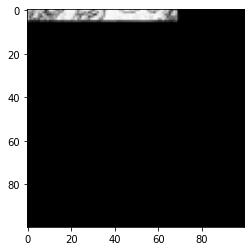

In [83]:
plt.imshow(arr[4314], cmap=plt.get_cmap("gray"))

In [88]:
os.getcwd()

'/media/harsh/harsh_4tb/Segmentations/P7/connectionPrediction_CNN1'

In [128]:
loss, acc = model.evaluate(train_ds)
print("Training loss and accuracy:")
print(loss, acc)

68/68 [==============================] - 0s 5ms/step - loss: 0.0073 - acc: 0.9979
Training loss and accuracy:
0.007322096909560701 0.99792963


In [129]:
loss, acc = model.evaluate(val_ds)
print("Validation loss and accuracy:")
print(loss, acc)

30/30 [==============================] - 0s 7ms/step - loss: 0.0237 - acc: 0.9925
Validation loss and accuracy:
0.02371114999987185 0.9924852


In [130]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

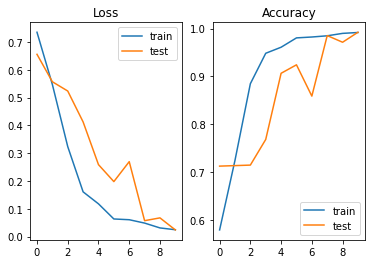

In [145]:
# plot loss during training
plt.subplot(121)#211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(122)#212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()